# ID5059 2022-23: Coursework Assignment 1

## Acknowledgments

This assignment is loosely based on the first assignment set by [Tom Kelsey](https://www.st-andrews.ac.uk/computer-science/people/twk/) in the 2020-21 delivery of ID5059. It uses data from the [Flight status prediction dataset](https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022) on [Kaggle](https://www.kaggle.com), posted by [Rob Mulla](https://www.linkedin.com/in/rob-mulla/).

### Get the data

This notebook is just intended to get you started: it includes enough to load one of the small datasets.

In [2]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Various parts of the dataset are [available on the CS teaching servers](https://wiki.cs.st-andrews.ac.uk/index.php?title=Teaching_Service) at the [following path](/cs/datasets/ID5059/Coursework1/). For the [small](/cs/datasets/ID5059/Coursework1/1_small) and [medium](/cs/datasets/ID5059/Coursework1/2_medium) files there's no harm in downloading them to your laptop or to your filespace in the lab, if that's convenient.

For the [large](/cs/datasets/ID5059/Coursework1/3_large) and [huge](/cs/datasets/ID5059/Coursework1/4_huge) files, you **must not download them to your filespace on the School servers**. If everyone does this it will take up too much disk space. This applies whether you are using a machine in the lab, or connecting to a School server from your laptop.

Instead, you must access such files directly from studres, e.g. at:

```/cs/datasets/ID5059/Coursework1/3_large/Combined_Flights_large_train_2022.csv```

If you want to download large files to the disk on your own laptop, that's up to you!

In [3]:
file_paths = [
    'Combined_Flights_med_2018.csv',
    'Combined_Flights_med_2019.csv',
    'Combined_Flights_med_2020.csv',
    'Combined_Flights_med_2021.csv',
    'Combined_Flights_med_2022.csv'
]

# Create an empty DataFrame to store all data
all_flights = pd.DataFrame()

# Loop through each file and add it to the all_flights DataFrame
for file_path in file_paths:
    flights_data = pd.read_csv(file_path, usecols=['Year', 'Month', 'Quarter', 'DayOfWeek', 'Distance', 'Airline', 'CRSDepTime', 'Origin', 'Dest', 'Disruption'])
    all_flights = pd.concat([all_flights, flights_data], ignore_index=True)

# Display the merged DataFrame
display(all_flights)


,Airline,Origin,Dest,CRSDepTime,Distance,Year,Quarter,Month,DayOfWeek,Disruption
0,United Air Lines Inc.,LAX,ORD,1845,1744,2018,3,7,5,0.0
1,Mesa Airlines Inc.,CRP,IAH,1757,201,2018,2,6,2,0.0
2,Southwest Airlines Co.,ECP,HOU,945,571,2018,3,7,2,0.0
3,United Air Lines Inc.,LAS,IAH,1015,1222,2018,4,10,7,0.0
4,ExpressJet Airlines Inc.,IAH,TUL,1856,429,2018,4,11,4,0.0
...,...,...,...,...,...,...,...,...,...,...
291930,Delta Air Lines Inc.,DCA,ATL,1705,547,2022,1,2,1,1.0
291931,United Air Lines Inc.,DFW,EWR,800,1372,2022,2,5,1,0.0
291932,Delta Air Lines Inc.,ATL,CLT,1513,226,2022,2,6,3,1.0
291933,American Airlines Inc.,TPA,ORD,1435,1011,2022,1,1,7,1.0


### Data Exploration


In [4]:
# Consider data types of attributes
all_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291935 entries, 0 to 291934
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Airline     291935 non-null  object 
 1   Origin      291935 non-null  object 
 2   Dest        291935 non-null  object 
 3   CRSDepTime  291935 non-null  int64  
 4   Distance    291935 non-null  int64  
 5   Year        291935 non-null  int64  
 6   Quarter     291935 non-null  int64  
 7   Month       291935 non-null  int64  
 8   DayOfWeek   291935 non-null  int64  
 9   Disruption  291925 non-null  float64
dtypes: float64(1), int64(6), object(3)
memory usage: 22.3+ MB


In [5]:
# descriptions of attribute
all_flights.describe()

,CRSDepTime,Distance,Year,Quarter,Month,DayOfWeek,Disruption
count,291935.000000,291935.000000,291935.000000,291935.000000,291935.000000,291935.000000,291925.000000
mean,1327.870536,779.787871,2019.828654,2.447250,6.323206,3.975799,0.201744
std,482.840567,581.305456,1.342526,1.120241,3.449016,2.005618,0.401302
min,1.000000,16.000000,2018.000000,1.000000,1.000000,1.000000,0.000000
25%,920.000000,354.000000,2019.000000,1.000000,3.000000,2.000000,0.000000
50%,1320.000000,628.000000,2020.000000,2.000000,6.000000,4.000000,0.000000
75%,1730.000000,1015.000000,2021.000000,3.000000,9.000000,6.000000,0.000000
max,2359.000000,5095.000000,2022.000000,4.000000,12.000000,7.000000,1.000000


In [7]:
#check the unique value
unique_values = all_flights.nunique()
print(unique_values)

Airline         28
Origin         387
Dest           386
CRSDepTime    1313
Distance      1668
Year             5
Quarter          4
Month           12
DayOfWeek        7
Disruption       2
dtype: int64


In [8]:
#calculate the number of missing vlaue(we can see the Disruption has 10 null values）
na_rows = all_flights.isna().sum(axis=0)
na_rows

Airline        0
Origin         0
Dest           0
CRSDepTime     0
Distance       0
Year           0
Quarter        0
Month          0
DayOfWeek      0
Disruption    10
dtype: int64

In [10]:
# check the relationship of those attributes

file_path = 'Combined_Flights_small.csv'
df = pd.read_csv(file_path)

categorical_features = [
'Year', 'Month', 'Quarter', 'Distance', 'Airline', 'CRSDepTime', 'DayOfWeek', 'Origin', 'Dest','Disruption'
]

chi2_results = []

for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['Disruption'])
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    if p_val < 0.05:
        chi2_results.append((feature, chi2_stat, p_val))

# Print the features with p-value < 0.05
for feature, chi2_stat, p_val in chi2_results:
    print(f"Feature: {feature}, Chi-Square: {chi2_stat}, p-value: {p_val}")


Feature: Year, Chi-Square: 158.571997040932, p-value: 2.9591580622899165e-33
Feature: Month, Chi-Square: 146.36683905272628, p-value: 8.22250362019373e-26
Feature: Quarter, Chi-Square: 40.80975733763077, p-value: 7.175821684910198e-09
Feature: Distance, Chi-Square: 1682.2873355570273, p-value: 9.375893810328118e-05
Feature: Airline, Chi-Square: 252.50266759664572, p-value: 1.765738525888543e-38
Feature: CRSDepTime, Chi-Square: 1617.4282499424303, p-value: 6.537406434211054e-17
Feature: DayOfWeek, Chi-Square: 33.31239306279313, p-value: 9.129793716659087e-06
Feature: Origin, Chi-Square: 541.9664567532338, p-value: 8.66518736232998e-09
Feature: Dest, Chi-Square: 553.1242207900773, p-value: 1.1966347320728648e-10
Feature: Disruption, Chi-Square: 29184.737289728248, p-value: 0.0


### Data cleaning


In [11]:
# Delete rows containing null values
all_flights.dropna(subset=['Disruption'], inplace=True)
# Convert the floating point value of the Disruption column to an integer value
all_flights['Disruption'] = all_flights['Disruption'].astype(int)

### Feature Engineering



In [12]:
# Create LabelEncoder instance
label_encoder = LabelEncoder()

# Encode the Origin column
all_flights['Origin'] = label_encoder.fit_transform(all_flights['Origin'])

# Encode the Dest column
all_flights['Dest'] = label_encoder.fit_transform(all_flights['Dest'])

# One-hot encoding the airline column into multiple binary feature representations
airline_encoded = pd.get_dummies(all_flights['Airline'], prefix='Airline')
all_flights = pd.concat([all_flights, airline_encoded], axis=1)
all_flights.drop('Airline', axis=1, inplace=True)

# Define feature columns and label columns
features = all_flights.drop(columns=['Disruption'])  # Feature columns are all columns except the target column
target = all_flights['Disruption']  # The target column is the column we want to predict

# Divide the dataset into training set and remainder
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)

# Divide the remaining part into a validation set and a test set, each accounting for half of the total data set.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Output the size of each data set
print("train:", X_train.shape[0])
print("vaild:", X_val.shape[0])
print("test:", X_test.shape[0])











train: 175155
vaild: 58385
test: 58385


Accuracy: 0.7954269075961291
Precision: 0.4423076923076923
Recall: 0.0038551793496480052
F1 Score: 0.007643735460285809


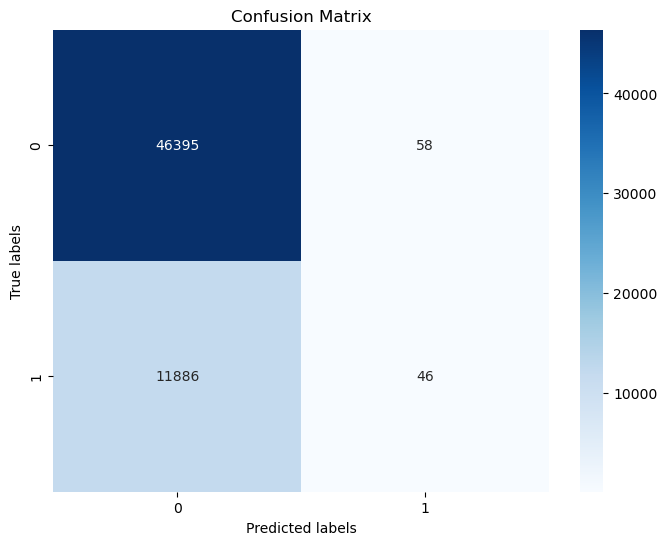

In [14]:

# Create a random forest model
rf_model = RandomForestClassifier(n_estimators=20, 
                                   max_depth=15, 
                                   min_samples_leaf=5, 
                                   n_jobs=-1, 
                                   random_state=42)

# Train the model on training data
rf_model.fit(X_train, y_train)

# Generate predictions and validate on validation set
y_pred = rf_model.predict(X_val)

# Output cross-validation accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate evaluation metrics
precision = precision_score(y_val, y_pred,zero_division=1)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

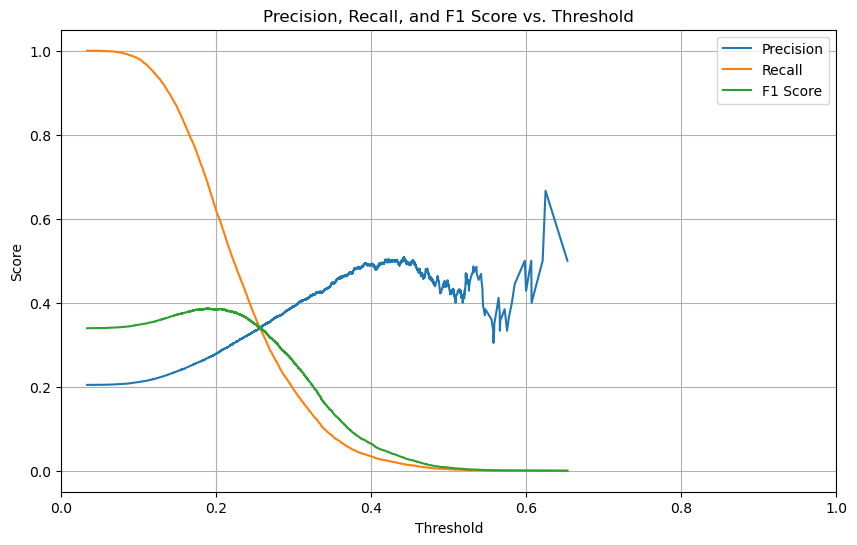

In [68]:

# Get the predicted probabilities on the validation set
y_scores = rf_model.predict_proba(X_val)[:, 1]

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall)

# Trim precision, recall, and f1_scores to match the length of thresholds
precision = precision[:-1]
recall = recall[:-1]
f1_scores = f1_scores[:-1]


# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.xlim(0.0, 1.0)  # Set the x-axis limits
plt.xticks(np.arange(0, 1.1, 0.2))  # Set x-axis tick marks at intervals of 0.2
plt.show()




Accuracy: 0.6887042904855699
Precision: 0.259124932479358
Recall: 0.2814280925243044
F1 Score: 0.269816399501828


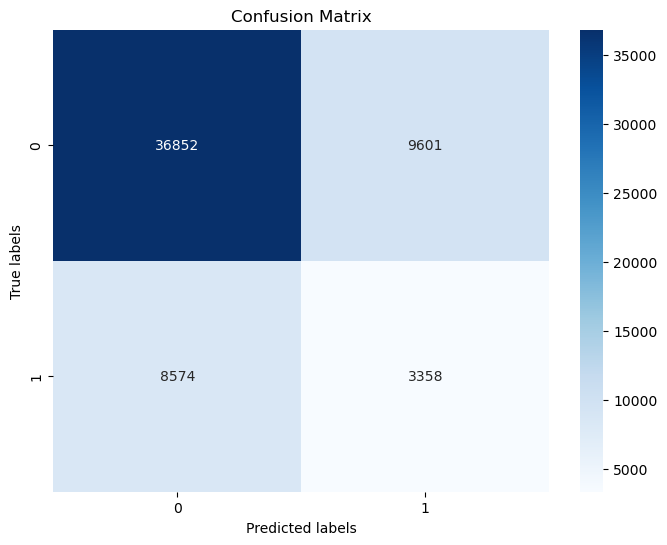

In [57]:

# Create the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
dt_model.fit(X_train, y_train)

# Generate predictions on the validation set
y_pred = dt_model.predict(X_val)

# Output accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Compute evaluation metrics
precision = precision_score(y_val, y_pred, zero_division=1)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


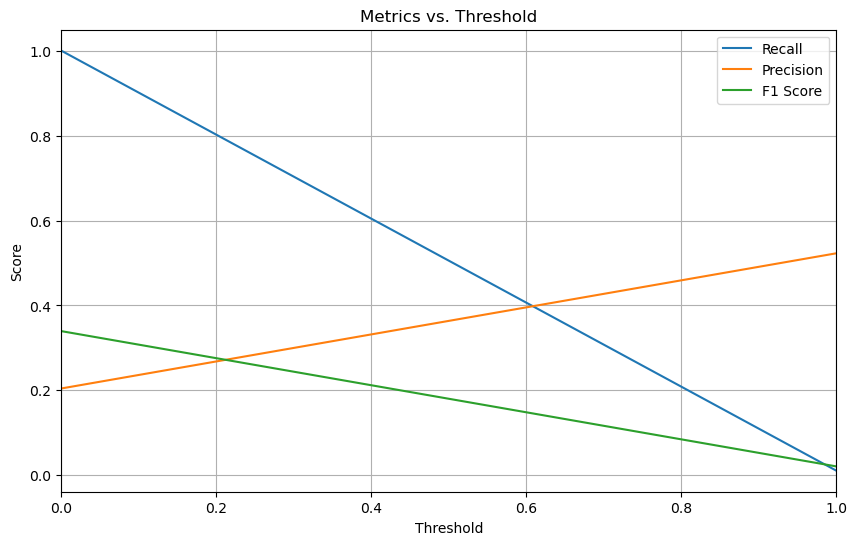

In [72]:
# Compute precision, recall, and F1 scores for various thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall)

# Trim precision, recall, and F1 scores to match the length of thresholds
precision = precision[:-1]
recall = recall[:-1]
f1_scores = f1_scores[:-1]

# Plot the curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs. Threshold')
plt.legend()
plt.grid(True)
plt.xlim(0.0, 1.0)  # Set the x-axis limits
plt.xticks(np.arange(0, 1.1, 0.2))  # Set x-axis tick marks at intervals of 0.2
plt.show()




Accuracy: 0.7958208443949645
Precision: 0.5228215767634855
Recall: 0.010559839088166276
F1 Score: 0.020701552616446232


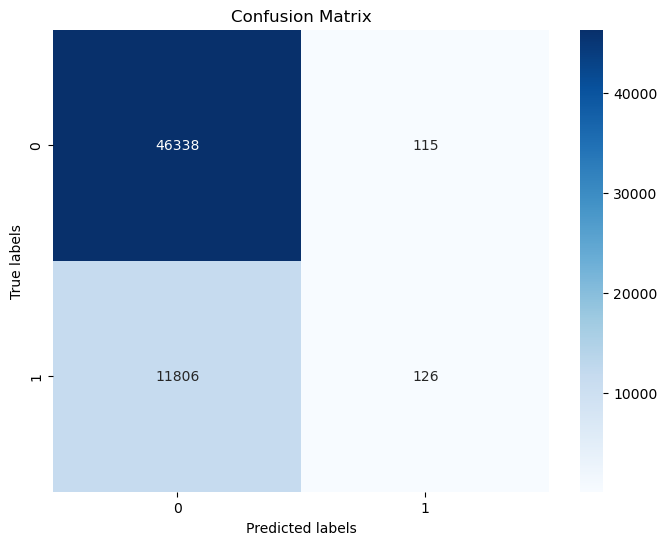

In [15]:

# Create the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)

# Train the model on the training data
gb_model.fit(X_train, y_train)

# Generate predictions on the validation set
y_pred = gb_model.predict(X_val)

# Output accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Compute evaluation metrics
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


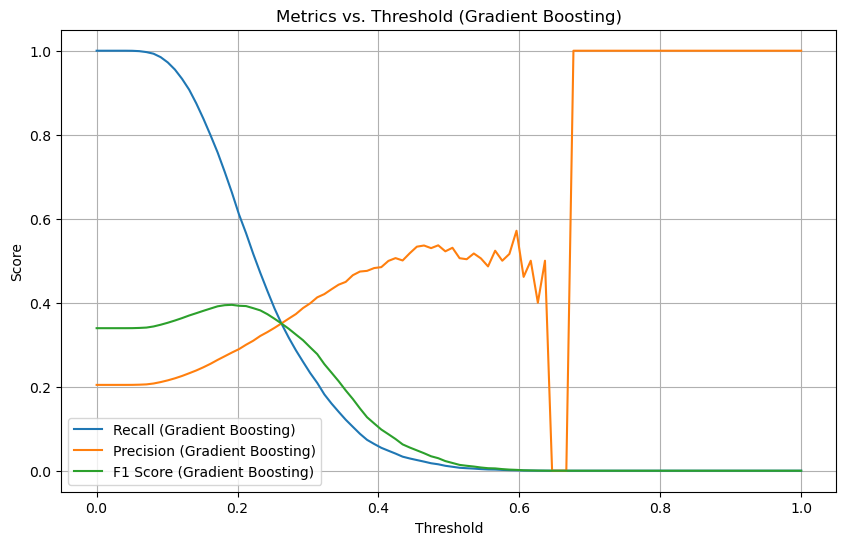

In [16]:
# First, get the predicted probabilities from the Gradient Boosting model
y_pred_prob_gb = gb_model.predict_proba(X_val)[:, 1]

# Define different thresholds
thresholds_gb = np.linspace(0, 1, 100)

# Initialize lists to store metrics
recalls_gb = []
precisions_gb = []
f1_scores_gb = []

# For each threshold, compute recall, precision, and F1 score
for threshold in thresholds_gb:
    # Convert predictions to binary based on the threshold
    y_pred_threshold_gb = (y_pred_prob_gb >= threshold).astype(int)
    # Compute recall, precision, and F1 score
    recalls_gb.append(recall_score(y_val, y_pred_threshold_gb))
    precisions_gb.append(precision_score(y_val, y_pred_threshold_gb, zero_division=1))
    f1_scores_gb.append(f1_score(y_val, y_pred_threshold_gb))

# Plot the curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds_gb, recalls_gb, label='Recall (Gradient Boosting)')
plt.plot(thresholds_gb, precisions_gb, label='Precision (Gradient Boosting)')
plt.plot(thresholds_gb, f1_scores_gb, label='F1 Score (Gradient Boosting)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs. Threshold (Gradient Boosting)')
plt.legend()
plt.grid(True)
plt.show()



### According to the image, we can know that the decision tree model has poor performance, while the Gradient Boosting Classifier has a high recall rate and F1 value. The random forest model has high accuracy but can only correctly identify a small number of true positive instances.


### ROC Curve


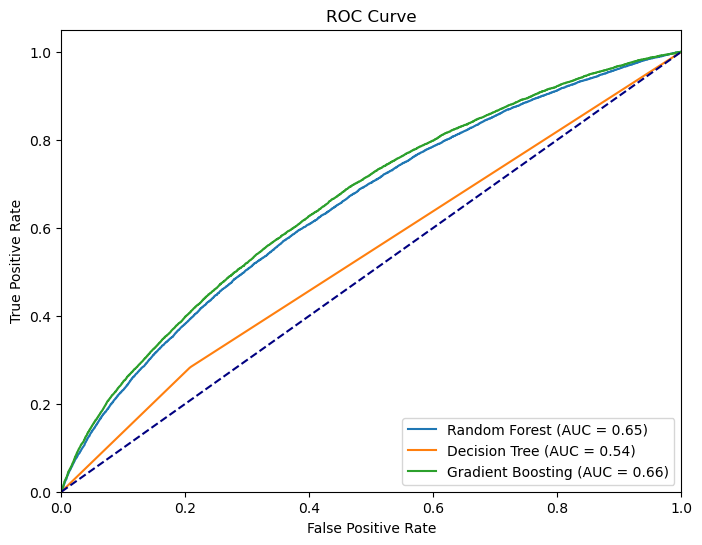

In [67]:

# Predicted probabilities from the Random Forest model
y_pred_rf_proba = rf_model.predict_proba(X_val)[:, 1]
# Predicted probabilities from the Decision Tree model
y_pred_dt_proba = dt_model.predict_proba(X_val)[:, 1]
# Predicted probabilities from the Gradient Boosting model
y_pred_gb_proba = gb_model.predict_proba(X_val)[:, 1]

# Calculate parameters for the ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_rf_proba)
fpr_dt, tpr_dt, _ = roc_curve(y_val, y_pred_dt_proba)
fpr_gb, tpr_gb, _ = roc_curve(y_val, y_pred_gb_proba)

# Calculate AUC scores
auc_rf = roc_auc_score(y_val, y_pred_rf_proba)
auc_dt = roc_auc_score(y_val, y_pred_dt_proba)
auc_gb = roc_auc_score(y_val, y_pred_gb_proba)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {auc_gb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



### Conclusion：Comparing these three models, the gradient boosting classifier has the largest area under the curve of 0.66. This means that the Gradient Boosting model has the best overall discriminative power for distinguishing positive and negative classes. Based on the above precision-recall rate curve, in order to achieve the goal of 90% recall rate, it is a reasonable solution to choose the gradient boosting classifier model.We have to lower the threshold to about 0.1.
。

### Hyperparameter Tuning


In [17]:

# Define the reduced hyperparameter grid
param_dist = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize RandomizedSearchCV with the pre-trained model
random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, n_iter=30, scoring='recall', cv=3, verbose=1, n_jobs=-1, random_state=42)

# Perform the random search
random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)



Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}
Best Score: 0.02195155855128514


In [20]:

# Create the Gradient Boosting model with the best hyperparameters
gb_model_best = GradientBoostingClassifier(n_estimators=200, 
                                            min_samples_split=2, 
                                            min_samples_leaf=2, 
                                            max_depth=5, 
                                            learning_rate=0.1, 
                                            random_state=42)

# Train the model on the training data
gb_model_best.fit(X_train, y_train)

# Generate predicted probabilities on the validation set
y_pred_proba_best = gb_model_best.predict_proba(X_val)[:, 1]

# Set the threshold to 0.1
threshold = 0.1

# Convert predicted probabilities to binary predictions based on the threshold
y_pred_binary_best = (y_pred_proba_best >= threshold).astype(int)

# Compute evaluation metrics for the binary predictions
accuracy_best = accuracy_score(y_val, y_pred_binary_best)
precision_best = precision_score(y_val, y_pred_binary_best)
recall_best = recall_score(y_val, y_pred_binary_best)
f1_best = f1_score(y_val, y_pred_binary_best)

print(f'Accuracy: {accuracy_best}')
print(f'Precision: {precision_best}')
print(f'Recall: {recall_best}')
print(f'F1 Score: {f1_best}')



Accuracy: 0.2914104650166995
Precision: 0.2187338772858426
Recall: 0.959353000335233
F1 Score: 0.3562436785186338


### Evaluation on test set



In [21]:


# Generate predicted probabilities on the test set
y_pred_proba_test = gb_model_best.predict_proba(X_test)[:, 1]

# Set the threshold to 0.1
threshold = 0.1

# Convert predicted probabilities to binary predictions based on the threshold
y_pred_binary_test = (y_pred_proba_test >= threshold).astype(int)

# Compute evaluation metrics for the binary predictions on the test set
accuracy_test = accuracy_score(y_test, y_pred_binary_test)
precision_test = precision_score(y_test, y_pred_binary_test)
recall_test = recall_score(y_test, y_pred_binary_test)
f1_test = f1_score(y_test, y_pred_binary_test)

print(f'Test Set Performance:')
print(f'Accuracy: {accuracy_test 
print(f'Precision: {precision_test}')
print(f'Recall: {recall_test}')
print(f'F1 Score: {f1_test}')


Test Set Performance:
Accuracy: 0.2898861008820759
Precision: 0.2145689275384527
Recall: 0.9609676589173887
F1 Score: 0.35080796692972566


### After evaluation, the model has good generalization ability and also achieved similar scores on the validation set. And the final model achieved the goal of at least 90% recall. The overall accuracy of the model is 28.98%.
